# Group-Specific Discriminant Analysis for sex-specific lateralization Running Demo

## Install essential packages

In [ ]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    !pip uninstall --yes yellowbrick
    !pip install -U -q psutil
    !pip install dgl dgllife
    !pip install rdkit-pypi
    !pip install PrettyTable yacs
    !git clone https://github.com/shuo-zhou/GSDA-Lateralization
    %cd GSDA-Lateralization
else:
    print('Not running on CoLab')
     

In [ ]:
from configs.default_cfg import get_cfg_defaults
from utils.experiment import run_experiment
from joblib import Parallel, delayed

## Set up the configurations

In [ ]:
# ---- setup configs ----
cfg_path = "configs/hcp_demo.yaml" # Path to `.yaml` config file

cfg = get_cfg_defaults()
cfg.merge_from_file(cfg_path)
cfg.freeze()
print(cfg)

DATASET:
  ATLAS: BNA
  CONNECTION: intra
  DATASET: HCP
  DOWNLOAD: True
  FEATURE: correlation
  MIX_GROUP: False
  NUM_REPEAT: 1
  REST1_ONLY: True
  ROOT: data
  RUN: Fisherz
  SESSIONS: [None]
  TEST_SIZE: 0.2
  TYPE: functional
OUTPUT:
  ROOT: output
SOLVER:
  ALPHA: 10
  LAMBDA_: [0.0, 2.0, 5.0, 10]
  LR: 0.08
  SEED: 2023


## Run experiments

It could take a while (15 to 25 mins) to run the experiments. 

In [ ]:
Parallel(n_jobs=2)(delayed(run_experiment)(cfg, lambda_) for lambda_ in cfg.SOLVER.LAMBDA_)
# run_experiment(cfg)

Training model with lambda = 0.0 on HCP dataset
Training model with lambda = 5.0 on HCP dataset
Training model with lambda = 10 on HCP dataset
Training model with lambda = 2.0 on HCP dataset


[None, None, None, None]

In [ ]:
from utils.io_ import load_result, reformat_results
from utils import plot

In [ ]:
dataset = cfg.DATASET.DATASET
model_root_dir = cfg.OUTPUT.ROOT
lambdas = cfg.SOLVER.LAMBDA_
seed_start = cfg.SOLVER.SEED
test_size = cfg.DATASET.TEST_SIZE

res_df_all = load_result(dataset=dataset, root_dir=model_root_dir, 
                         lambdas=lambdas, seed_start=seed_start, test_size=test_size)
# res_df_all["gap_train_session"] = res_df_all["acc_tgt_train_session"] - res_df_all["acc_nt_train_session"]
# res_df_all["gap_test_session"] = res_df_all["acc_tgt_test_session"] - res_df_all["acc_nt_test_session"]
res_df_all["GSI_train_session"] = 2 * (res_df_all["acc_tgt_train_session"] * 
                                       (res_df_all["acc_tgt_train_session"] - 
                                        res_df_all["acc_nt_train_session"]))
res_df_all["GSI_test_session"] = 2 * (res_df_all["acc_tgt_test_session"] * 
                                      (res_df_all["acc_tgt_test_session"] - 
                                       res_df_all["acc_nt_test_session"]))

res_df_is = reformat_results(res_df_all, ["acc_tgt_train_session", "acc_nt_train_session"])
res_df_os = reformat_results(res_df_all, ["acc_tgt_test_session", "acc_nt_test_session"])

res_df_all.loc[res_df_all["train_group" ]==0, "train_group" ] = "Male"
res_df_all.loc[res_df_all["train_group" ]==1, "train_group" ] = "Female"

FileNotFoundError: [Errno 2] No such file or directory: 'figures/HCP_in_session_test0.2.svg'

<Figure size 640x480 with 0 Axes>

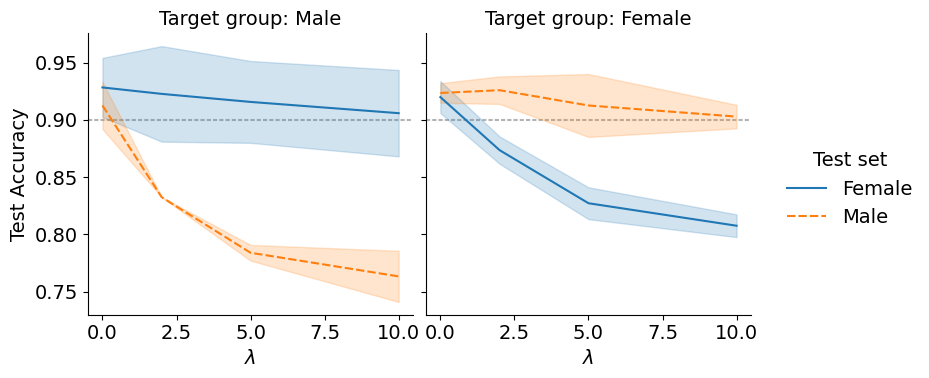

In [ ]:
plot.plot_accuracy(res_df_is, outfile="figures/HCP_in_session_test%s" % test_size, outfig_format=["svg", "pdf"])

FileNotFoundError: [Errno 2] No such file or directory: 'figures/GSI_box_HCP_in_session_test.svg'

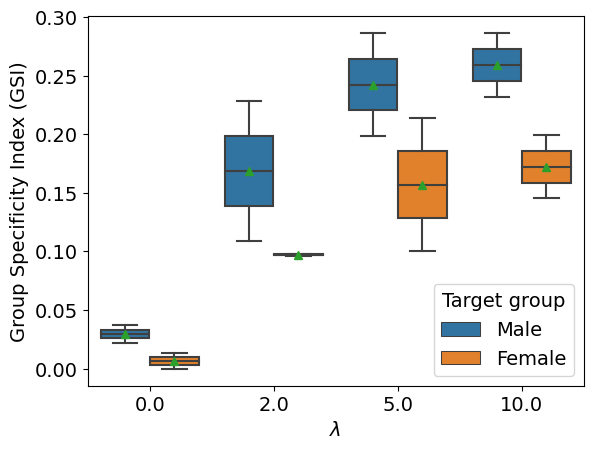

In [ ]:
plot.plot_gsi(res_df_all, x="lambda", y="GSI_train_session", hue="train_group", outfile="figures/GSI_box_HCP_in_session_test", outfig_format=["svg", "pdf"])